In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import Image
import time

In [19]:
# Setup Parameters: 

# 1. Canny Edge Detector Parameters:
minVal = 100
maxVal = 200

# 2. Hough Transform Parameters: 
res_rho = 1             # pixels
res_theta = np.pi/135   # radians
min_thresh = 100

# 3. Segment Threshold: 
segThresh = 20  # pixels

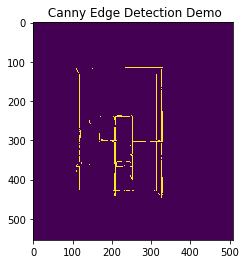

In [13]:
# Read in the input image in grayscale: 
img_gray = cv2.imread('RVIZ_UAV_Test_image#1.png',0)


# Run the Canny Edge detector on the image: 
# Parameters: 1. minVal - If the value of the intensity gradient at a potential edge point is less than minVal then that point is discarded
#             2. maxVal - If the value of the intensity gradient at a potential edge point is greater than maxVal then it is surely an edge point

img_canny = cv2.Canny(img_gray, minVal, maxVal)


#ret, img_canny = cv2.threshold(img_gray, 127, 255, 0)

# Display the image for verification: 
plt.imshow(img_canny)
plt.title(" Canny Edge Detection Results")
plt.show()



In [20]:

# Task #1: Custom Hough Transform: 

# Parameters:
# 1. Resolution for rho - Normal Distance from origin to the line
# 2. Resolution of theta - Angle made by the normal with the X-axis
# 3. Threshold on min number of votes - Minimum no of votes needed for a line to be considered: 

# res_rho = 1
# res_theta = np.pi/135
# min_thresh = 60

# Important formula to remember is: xcos(theta) + y sin(theta) = rho.


# Range of rho is the diagonal of the image: 
[h,w]= img_gray.shape
img_diag = np.sqrt(h**2 + w**2)



# Create an accumulator matrix of the appropriate size: 
acc_h = int(img_diag/res_rho)  # Rows of the matrix
acc_w = int(np.pi/res_theta)   # Columns of the matrix


acc_mat = np.zeros((acc_h,acc_w))

# Create a matrix to store the points which vote for each cell in the accumulator matrix:
point_mat  = np.empty([acc_h,acc_w], dtype= np.object)

# Now fill the matrix with empty list at each location: 
point_mat.fill([])

# Override the broadcast: Need to understand this: 
point_mat = np.frompyfunc(list,1,1)(point_mat)


# Find the indices where edge pixels are located:
[y_edge, x_edge] = np.where(img_canny == 255)


# Avoid calling the sin and cos functions repeatedly inside the loop:
c_theta = np.cos(np.arange(0,np.pi, np.pi/135))
s_theta = np.sin(np.arange(0,np.pi, np.pi/135))

start_time = time.time()

# Now loop over the edge pixels and get their votes:
# Loop through and fill the accumulator matrix and store the points which vote for each bin: 
for x,y in zip(x_edge, y_edge):  
    
    for theta_ind in np.arange(0,acc_w):
        
        rho_ind = int((x*c_theta[theta_ind] + y*s_theta[theta_ind])/res_rho)
        
        acc_mat[rho_ind,theta_ind] +=1
        
        point_mat[rho_ind, theta_ind].append((x,y))        

end_time = time.time()

print ("Time to create accumulator matrix and store points is" , end_time - start_time)
        

# Find the indices where the no of votes exceeds the min threshold: 
[rho_ex, theta_ex] = np.where(acc_mat > min_thresh)

# For the bins which met the criteria get the equations of the lines and the corresponding points which voted for that bin:
lines =[]  # List of tuples to store the parameters (rho, theta) of each line
list_points = []   # List of lists where each nested list contains tuples of the points which voted for each line


st = time.time()
for rho,theta in zip(rho_ex , theta_ex):
    
    lines.append((rho*res_rho , theta*res_theta))

    list_points.append(point_mat[rho,theta])
et = time.time()


print ("Time to collect info about lines and points is" ,et - st)


# Get the number of lines:
print (" The number of lines generated is : ")
print (len(lines)) 
    



Time to create accumulator matrix and store points is 3.2742974758148193
Time to collect info about lines and points is 0.00014257431030273438
 The number of lines generated is : 
13


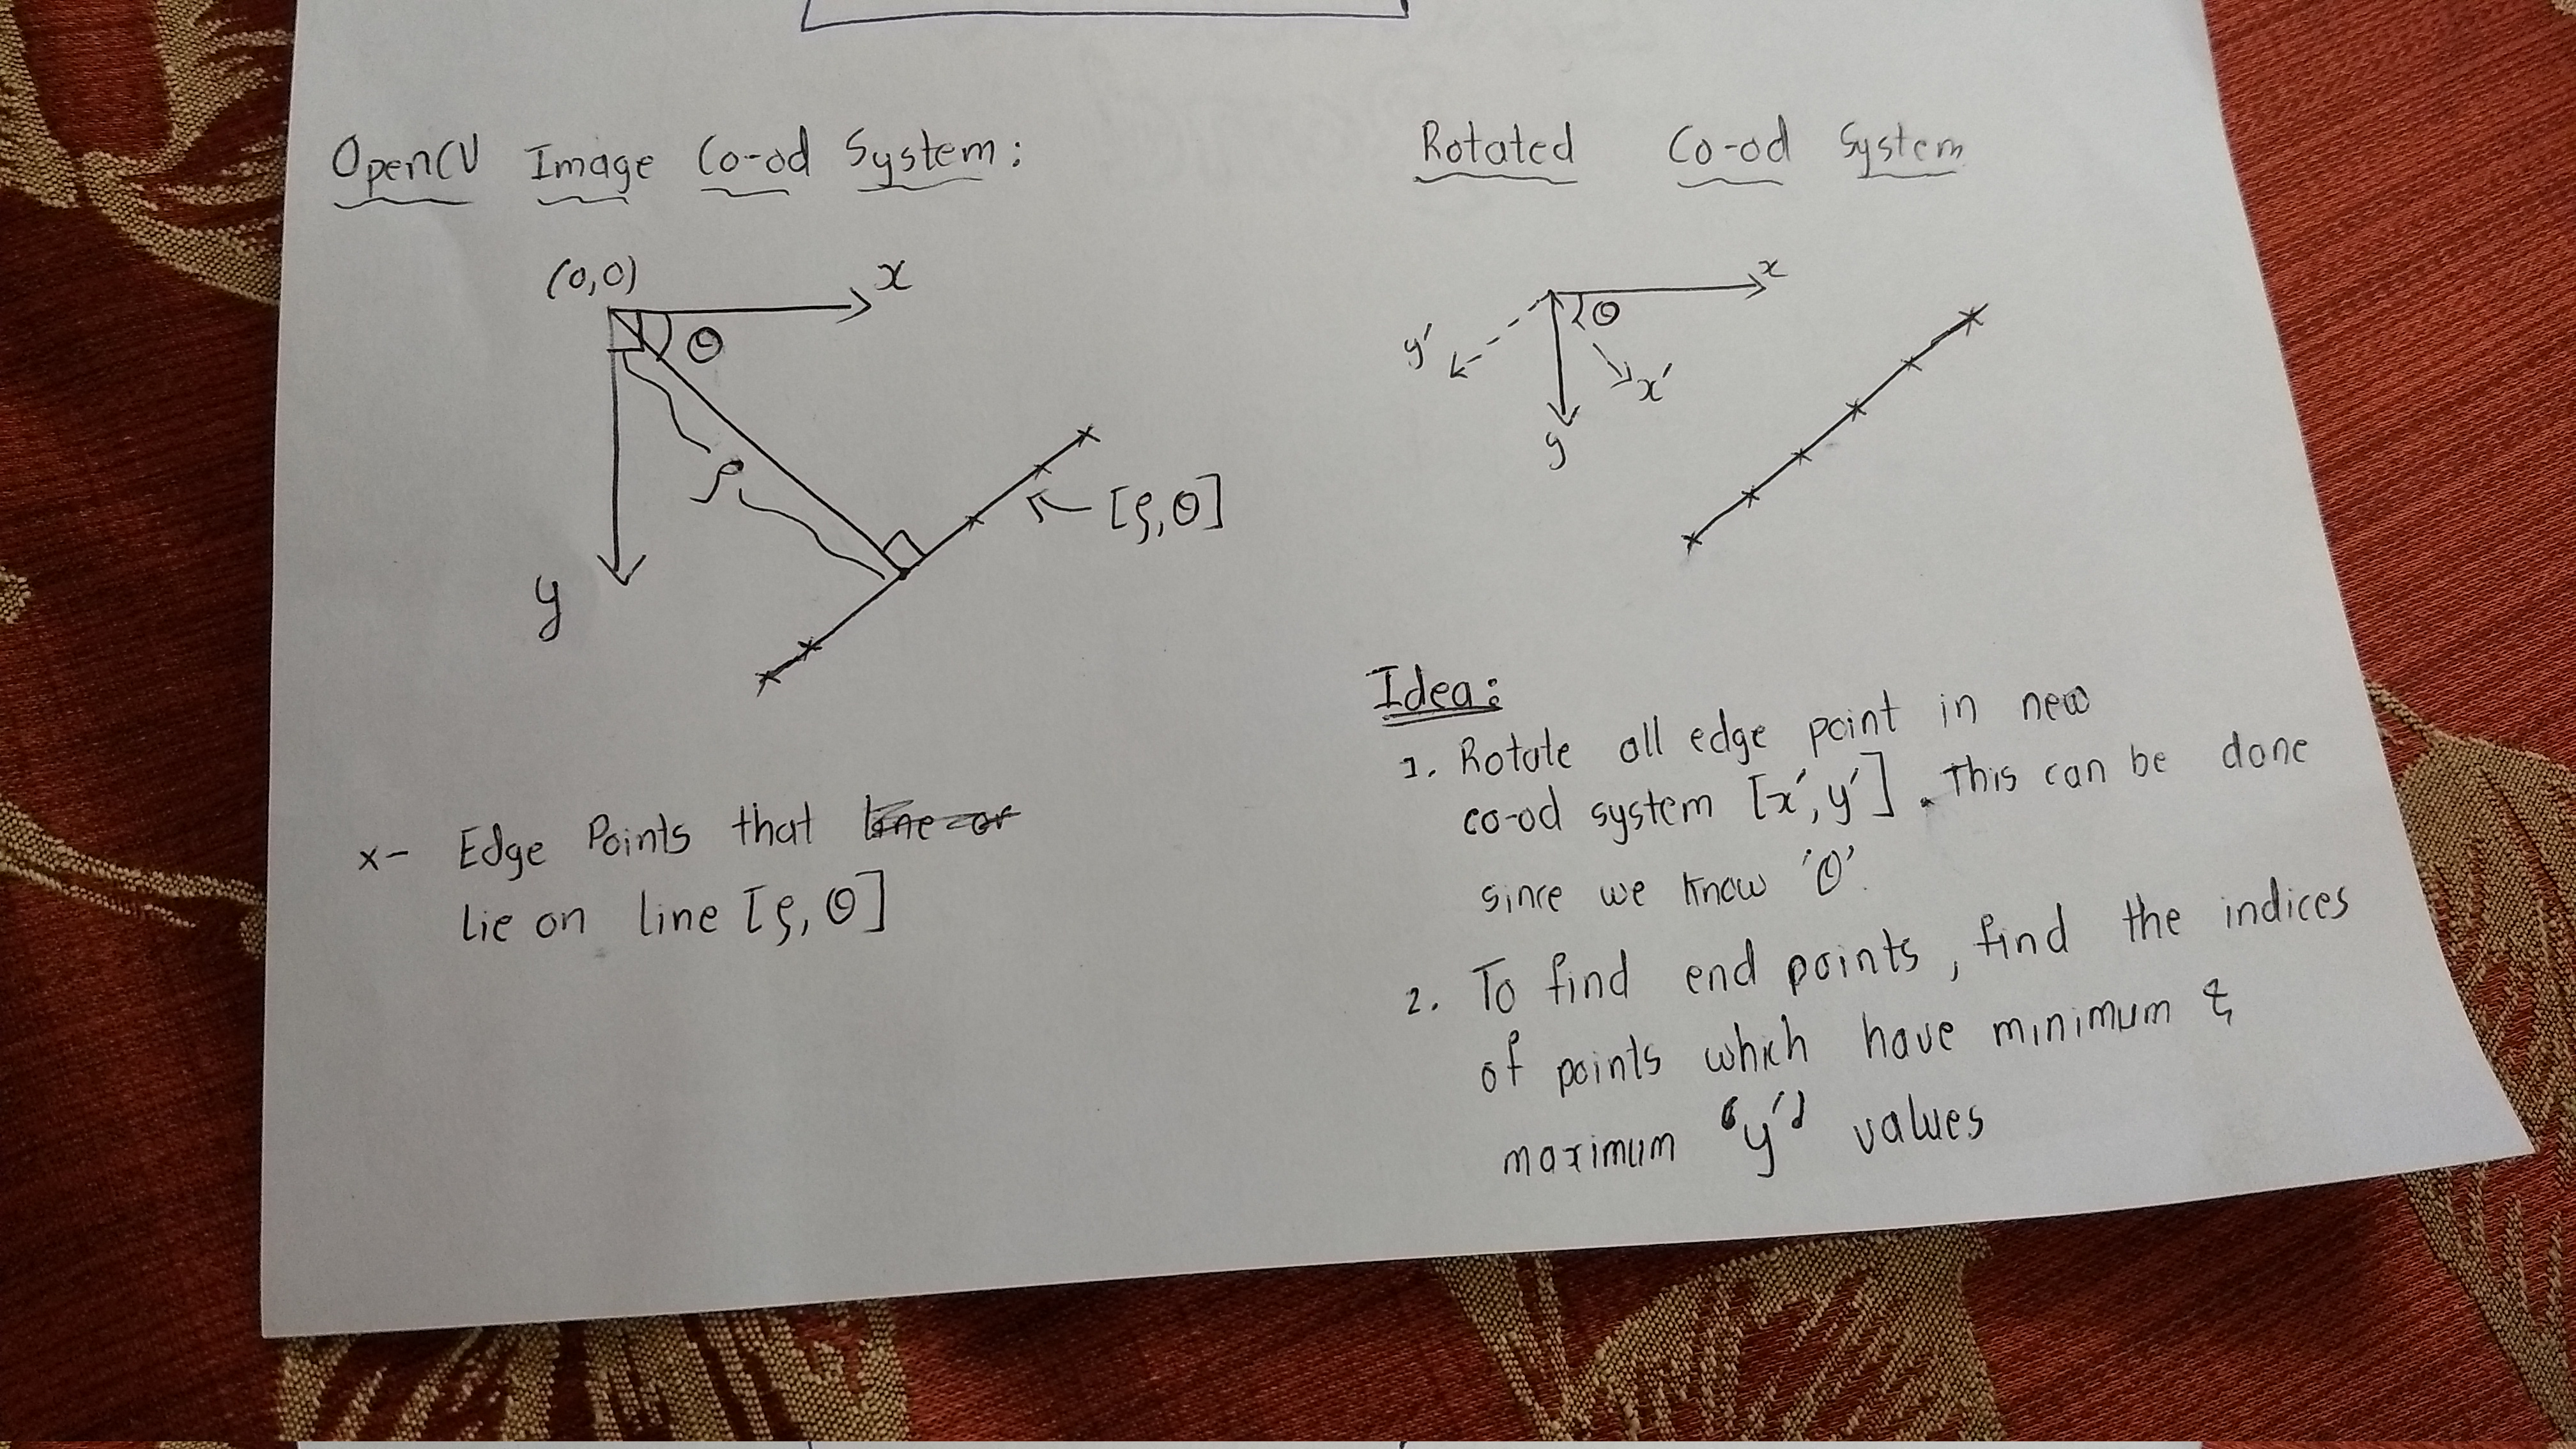

In [21]:
# Display the concept for finding the the end points of segments in the image: 
Image("Hough_ New.jpg")

In [23]:
# Task #2: Finding the end points for each segment: 

# For each line: 
#   Rotate the points so that the new co-od system whose y -axis is parallel to the line.  

#   Find the points which have the minimum and maximum y'-coods: 
#        In practice this is not a good idea since multiple parallel segments can be part of one line
#        Thus, we sort the y' coods and then iterate over them from smallest to largest
#                 If the current y'cood is greater than then previous one by a certain threshold (tuning parameter)
#                 then we end the current segment at the previous cood and begin a new segment at the current cood

#   List with the x and y co-ordinates  of the end points of each segment:
end_points = []

st = time.time()
for points, line in zip(list_points, lines):
    
    y_prime = np.zeros(len(points))
    
    count =0
    
    for point in points: 
        
        # Rotate each of the points to the new co-ordinate system: (x', y')
        # We only need to find the rotated y' co-ordinates:
        # line[1] - stores the value of theta
        y_prime[count] = np.sin(line[1])*point[0] + np.cos(line[1])*point[1]
        count+=1
    
    
    # Add a sub-routine here to split the points belonging to a single line: 
    
    # Sort the y' coordinates: 
    ind_sort = np.argsort(y_prime)
    
    
    start = points[ind_sort[0]]
    
    for i in np.arange(1, len(ind_sort)): 
        
        if abs(y_prime[ind_sort[i]] - y_prime[ind_sort[i-1]]) > segThresh: 
            
            end = points[ind_sort[i-1]]
            end_points.append((start,end))
            
            start = points[ind_sort[i]]
        
    
    end = points[ind_sort[count-1]]   

    
    end_points.append((start,end))
    
    
et = time.time()  

print ("Time to find end points is" ,et - st)


print (" The number of segments generated is: ")
print(len(end_points))

Time to find end points is 0.011320352554321289
 The number of segments generated is: 
30


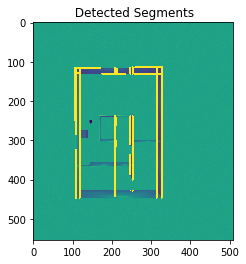

In [26]:
# Task #3: Validate the end points: 

# Start by drawing a few of the segments on the image using the OpenCV functions: 
# Draw a line: Parameters are: 
# 1) The input image, 2) Start point - Tuple of x and y coods, 3) End point - Tuple of x and y co-ods. 4) Color - Tuple of BGR
# 4) Line thickness in px

img_gray = cv2.imread('RVIZ_UAV_Test_image#1.png',0)
img_draw = img_gray

for i in np.arange(0,len(end_points)): #len(lines)):
    
    img_draw = cv2.line(img_draw, end_points[i][0], end_points[i][1], (255,0,0), 3)
    



# Now display the image using MATPLOTLIB: MATPLOTLIB coloring scheme is weird:
# Plot the image: 
plt.imshow(img_draw)
plt.title(" Detected Segments - In Yellow")
plt.show()